# Mycoplasma Bovis analysis

Links

* https://www.ncbi.nlm.nih.gov/genome/browse/#!/prokaryotes/1150/

Bioprojects:

* Genomic epidemiology of Mycoplasma bovis in France: SRP386998
* Genome-Wide Identification of Variants Associated with Antimicrobial Resistance in Mycoplasma bovis: SRP349146/PRJNA785928
* Sanger Full_genome_sequencing_of_Mycoplasma_species_isolates_from_ruminants (Israel): PRJEB3408
* Mycoplasmopsis bovis Genome sequencing and assembly (China): PRJNA1021812
* WGS Australian Mycoplasma bovis isolates: PRJNA335520
* Comparative genomics of mycoplasma bovis: PRJNA602897 (DTU)
* Mycoplasma bovis genomes from the New Zealand outbreak: PRJNA664415
* De novo genome assembly of 36 Mycoplasma bovis strains: PRJNA954308

Refs:

* [Genomics-based epidemiology of bovine Mycoplasma bovis strains in Israel](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6460-0#Sec13)
* [Population Genomic Analysis of Mycoplasma bovis Elucidates Geographical Variations and Genes associated with Host-Types](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7650767/)
* [Identification of Antimicrobial Resistance-Associated Genes through Whole Genome Sequencing of Mycoplasma bovis Isolates with Different Antimicrobial Resistances](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7400188/)

Ref strain:

* https://www.culturecollections.org.uk/nop/product/mycoplasma-bovis

In [12]:
import os,sys,subprocess,glob,re
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import geopandas as gpd
from importlib import reload
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio import AlignIO
from snipgenie import app, tools, trees, clustering, plotting, aligners
pd.options.display.max_rows = 200
pd.set_option('display.width', 1000)

In [13]:
mycolors = {
  'Ireland': "#4AA60E",
  'Scotland': "#BDDC28",
  'Germany' : "#F34DA5",
  'Denmark': "#C029C5",
  'Finland' : "#0969A2",
  'Poland' : "#FF8C00",
  'Netherlands' : "#03436A",
  'Lithuania' : "#B0F26D",  
  'New Zealand' : "#FF3D00",
  'Canada' : "#FF9473",
  'France' : "#A62800",
  'Russia' : "#D1D3C8",
  'Ethiopia' : "#FFC073",
  'Australia' : "#CF7143",
  'Israel' : "#CFA127",  
  'Sweden':"#E6E450",
  'Belgium':"#6A157F",
  'Spain':"#33B46E",
  'China':"#74E600",
  'USA' : "#5ACDF1",
  'Europe':"#09173D" }

In [17]:
#sra samples stats
srafiles = glob.glob('*_runTable.csv')
res=[]
for f in srafiles:
    df=pd.read_csv(f)
    res.append(df)
runs=pd.concat(res).drop(columns=['strain'])
runs.geo_loc_name_country.value_counts()
#runs.BioProject.value_counts()

New Zealand    594
France         102
Australia       82
Denmark         77
Canada          70
USA             27
Sweden          10
Netherlands      9
China            2
Finland          1
Estonia          1
Name: geo_loc_name_country, dtype: int64

In [ ]:
#get selected runs
x=runs[runs.geo_loc_name_country.isin(['France'])]
for i,r in x.sample(2,random_state=1).iterrows():
    print (r)
    f = glob.glob(os.path.join('sra/{}*'.format(r.Run)))
    if len(f)==0:
        cmd = 'fastq-dump --split-files %s' %r.Run
        print (cmd)
        subprocess.check_output(cmd, shell=True)

In [20]:
#check assembled against assemblies for duplicates
asm = pd.read_csv('assembly_details.csv')
#srameta[srameta.BioSample.isin(asm.BioSampleAccn)]

In [52]:
gmeta = pd.read_csv('global_meta.csv',index_col=0)

# meta data for all samples

In [15]:
#make table for all meta data
samples = pd.read_csv('results/samples.csv',index_col=0)
meta=pd.read_csv('metadata.csv')
meta = meta[meta.status!='removed']

In [16]:
#print (meta[:2])
#srameta = samples.merge(runs,left_on='sample',right_on='Run',how='left').dropna(subset='geo_loc_name_country')
srameta = runs
cols=['sample','country','strain','BioSample','BioProject']
srameta = srameta.rename(columns={'Run':'sample','Sample Name':'strain','geo_loc_name_country':'country'})

meta = pd.concat([meta,srameta[cols]]).reset_index(drop=True)
meta.to_csv('metadata_all.csv',index=False)

In [11]:
## submission table
cols = ['sample','strain','filename1','filename2']
s = samples.merge(meta,on='sample',how='right')
s[cols].to_csv('/other/catherine/submission/samples.csv',index=False)

## assembly meta data

In [21]:
def func(x):
    return re.sub(r'\.(1|2)', '', x)

asm['name'] = asm.GenbankAccession.apply(func,1)
asm['country'] = asm.geo_loc_name.fillna('').apply(lambda x: x.split(':')[0])
asm['year'] = pd.to_datetime(asm.collection_date,format='mixed',errors='coerce',yearfirst=True).dt.year
asm=asm.drop_duplicates('name')
asm=asm.set_index('name')

In [36]:
#combine assembly
asmcols =['id','AssemblyAccession','BioSampleAccn','BioSampleId','SubmitterOrganization',
          'strain','host','collection_date','geo_loc_name','country','year']
asm[asmcols]
final = pd.concat([meta.set_index('sample'),asm[asmcols]])

In [37]:
def get_region(x):
    if x in ['UK','France','Belgium','Lithuania','Russia','Hungary','Netherlands',
             'Denmark','Ireland','Scotland','Spain','Turkey',
             'Sweden','Finland','Austria','Germany','Poland','Romania']:
        return 'Europe'
    elif x in ['USA','Canada']:
        return 'North America'
    elif x in ['China','Japan','Thailand']:
        return 'Asia'
    elif x in ['New Zealand','Australia']:
        return 'Oceania'
    return x
final['region'] = final.country.apply(get_region)

In [38]:
def get_species(x):
    if x in ['Bos taurus','calf','cattle','bovine','yak','Cow']:
        return 'Cow'
    if x in ['bison','Bison bison']:
        return 'Bison'
    elif x in ['mule deer','white tail deer','Odocoileus hemionus']:
        return 'Deer'
    else: return x
    
final['species'] = asm.host.apply(get_species)

In [39]:
st=pd.read_csv('st_types.csv',index_col=0)
final=final.merge(st,left_index=True,right_index=True,how='left')

In [40]:
final.to_csv('global_meta.csv')

## updated tree with homoplasies removed

In [589]:
haln = AlignIO.read('results/sequences_noInconsistentSites_05-04-24.fasta','fasta')
newdm =tools.snp_dist_matrix(haln)
newdm.to_csv('results/newtree/snpdist.csv')
out='results/newtree/'
treefile = trees.run_RAXML('results/sequences_noInconsistentSites_05-04-24.fasta', outpath=out, threads=12)
ls = len(haln[0])
trees.convert_branch_lengths(treefile,'results/newtree/tree.newick', ls)

## clustermap

In [45]:
newdm = pd.read_csv('results/newtree/snpdist.csv',index_col=0)
gdm = pd.read_csv('panaroo_global/snpdist.tsv',sep='\t',index_col=0)

In [30]:
dm = pd.read_csv('results/snpdist.csv',index_col=0)

In [69]:
clade1 = ['221', '223', '224', '228', '234', '240', '222A', '224B21', '226-B21', '229-B21', '230-B21',
        'SCOT1', 'SCOT2', 'SCOT3', 'SCOT4', 'GB000944', 'GB17005644', 'GB18000923',
         'GCA_029855485','GCA_029989505','SRR10958113','SRR10958193'] # european samples in this clade

clade2 = ['241','245','243-B21','227','GB18001319','GCA_029855765',
          'SRR10958101','SRR12674172','SRR12686435', 'SRR12673135','SRR12673179',      
          'GCA_016452845', #others
          'GCA_020422985']

In [ ]:
list(meta[~meta['sample'].isin(clade2)]['sample'])

In [47]:
def lower_matrix_clustermap(X, rcolors=None, xticklabels=1, yticklabels=1, cmap='Blues'):
    """Lower matrix clustermap with row colors"""
    
    #get mask
    corr = X.to_numpy()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    g = sns.clustermap(corr, mask=mask, vmax=.3, figsize=(0.05,0.05))
    mask = mask[np.argsort(g.dendrogram_row.reordered_ind),:]
    mask = mask[:,np.argsort(g.dendrogram_col.reordered_ind)]    
    cg=sns.clustermap(X, cmap=cmap,  mask=mask, row_colors=rcolors, col_colors=rcolors, xticklabels=xticklabels, yticklabels=yticklabels, 
                      figsize=(9,7), annot=True, annot_kws={'size':6},fmt='.0f',linewidths=.005,linecolor='lightgray',linestyle='--')
    p=plotting.make_legend(cg.fig, cm, loc=(1.2, .6), title='country',fontsize=10)
    return

#idx = gmeta[gmeta.country.isin(['Ireland','New Zealand','Finland'])]['sample']
#sub = gmeta[meta['sample'].isin(idx)]
#rcolors,cm=plotting.get_color_mapping(sub,'country')
#rcolors = list(sub.country.map(cm))
#X = gdm.loc[idx,idx]
#lower_matrix_clustermap(X, rcolors)

## dm vs locations?

In [42]:
borders = gpd.read_file('counties.shp').to_crs('EPSG:29902')

In [48]:
def random_point_in_polygon(x):
    from shapely.geometry import Point
    polygon = x.geometry
    if polygon is None:
        return
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        point = Point(x, y)
        if polygon.contains(point):
            return point

(41.04789302291829,
 384254.86014362023,
 -6200.9255171295445,
 488144.80122018646)

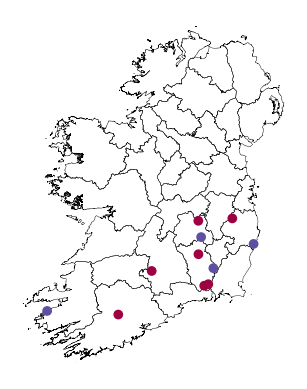

In [50]:
sub = meta[meta.country.isin(['Ireland'])]
idx = sub['sample']
X = gdm.loc[idx,idx]
cl,l = clustering.get_cluster_levels(X)
sub=sub.merge(cl,left_on='sample',right_index=True)
sub = borders[['NAME_TAG','geometry']].merge(sub,left_on='NAME_TAG',right_on='county',how='right')
sub['geometry'] = sub.apply(random_point_in_polygon,1)

#sub=gpd.GeoDataFrame(sub)
ax=borders.plot(color='none',lw=.3)
sub.plot(ax=ax,column='clade',cmap='Spectral')
ax.axis('off')

In [186]:
#C=pd.read_csv('results/csq.matrix').T
csq = app.read_csq_file('results/csq.tsv')
aamat = app.get_aa_snp_matrix(csq)

## check duplicates

In [ ]:
for pair,df in samples.groupby('pair'):
    if len(df) == 1:
        continue        
    print (pair)
    #print (df)
    x=list(df['sample'])        
    print (dm.loc[x,x])

In [ ]:
tools.get_unique_snps(['227A'],aamat)

## deletions

In [9]:
from snipgenie import rdiff
sub=samples.sample(10,random_state=2)
regions = rdiff.get_deletions(samples, ref, refgb, #mask_file=app.mbovis_mask,
                              label='sample', min_coverage=0, n_cores=12)
regions.to_csv('deletion_regions.csv',index=False)

In [ ]:
regions = pd.read_csv('deletion_regions.csv')
res=regions[regions.length>2000]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
X=X.clip(0,1)
X=X.droplevel(1)

sns.clustermap(X,cmap='Blues',yticklabels=True,row_cluster=False,lw=.4,linecolor='.8',figsize=(14,10))

#write a mask file?
#X

In [ ]:
s=590804;e=s+1000
rdiff.show_coverage(samples, 'NC_014760.1',s,e,ref,refgb,margin=1300)

## assembly

In [ ]:
for i,r in samples.iterrows():    
    name = r['sample']
    print (name)
    if name in ['pure']: continue
    tools.spades(r.filename1,r.filename2, os.path.join('assembly',name), 'assembly/%s.fa' %name, 12)

In [ ]:
n='SRR3954761'
tools.spades(f'/other/catherine/sra/{n}_1.fastq.gz', f'/other/catherine/sra/{n}_2.fastq.gz', 
             os.path.join('assembly',n), f'assembly/{n}.fa', 12)

## polish assembly with pilon

In [ ]:
reload(aligners)
for i,r in samples[25:].iterrows():
    name = r['sample']
    infile = 'assembled/%s.fa' %name
    out = 'polished/%s.bam' %name
    aligners.build_bwa_index(infile)
    aligners.bwa_align(r.filename1, r.filename2, infile, out, threads=12)
    aligners.bam_index(out)
    #run pilon
    cmd = 'pilon --genome {i} --changes --frags {o} --output {n} --outdir polished'.format(i=infile,o=out,n=name)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    

In [ ]:
## assembly stats
a = pd.read_csv('quast_results/results_2024_04_03_20_39_45/report.tsv',sep='\t',index_col=0)
a.T.describe()

In [534]:
red = pd.read_csv('reduced_genomes.txt',names=['file','sample'],sep='\t')


## mean GC for assemblies

In [ ]:
files = glob.glob('assembled/*.fa')
files = glob.glob('entrez_assemblies/*.fna')
reload(tools)
res = []
for f in files:    
    name = os.path.splitext(os.path.basename(f))[0]  
    #print (name)
    gc = tools.get_fasta_gc(f)    
    res.append([name,gc])
res = pd.DataFrame(res,columns=['sample','GC'])
res.mean()

## annotation

In [ ]:
out='annot_global'
#files = glob.glob('assembled/*.fa')
trusted = 'CP002188.gb'

for f in files:    
    name = os.path.splitext(os.path.basename(f))[0]    
    cmd = '/local/prokka/bin/prokka --proteins {p} --outdir {o}/{n} {f} --prefix {n}'.format(p=trusted,f=f,n=name,o=out)#,p=path)    
    if not os.path.exists('%s/%s' %(out,name)):
        print (cmd)
        subprocess.check_output(cmd, shell=True)

In [105]:
out='annot_global'
trusted = 'CP002188.gb'
red = pd.read_csv('reduced_genomes.txt',names=['file','sample'],sep='\t')

for i,r in red.iterrows():    
    name = r['sample']
    cmd = '/local/prokka/bin/prokka --proteins {p} --outdir {o}/{n} {f} --prefix {n}'.format(p=trusted,f=r.file,n=name,o=out)#,p=path)    
    if not os.path.exists('%s/%s' %(out,name)):
        print (cmd)
        #subprocess.check_output(cmd, shell=True)


In [ ]:
out='annot_NZ'
trusted = 'CP002188.gb'
files = glob.glob('NZ_results/assembled/*',recursive=True)
for f in files:
    name = os.path.splitext(os.path.basename(f))[0]
    cmd = '/local/prokka/bin/prokka --proteins {p} --outdir {o}/{n} {f} --prefix {n}'.format(p=trusted,f=f,n=name,o=out)
    if not os.path.exists('%s/%s' %(out,name)):
        print (cmd)
        subprocess.check_output(cmd, shell=True)


In [18]:
files = glob.glob('annot_NZ/**/*.gff',recursive=True)
import shutil
for f in files:
    shutil.copy(f, os.path.join('gff_NZ',os.path.basename(f)))

## panaroo

In [14]:
def get_presence_absence(df, cols=None):
    """parse roary file"""
    
    if cols is None:
        cols = df.columns
    x=df.copy()
    #x['cat'] = x.Annotation.apply(lambda x: apply_cat(x))
    #x = x.set_index(['cat','Gene','Annotation'])
    x = x.set_index(['Gene','Non-unique Gene name','Annotation'])
    x = x[cols[3:]].notnull().astype('int')
    #x = x.loc[x.index.dropna()]
    return x

def apply_cat(x):
    keys=['ARO','efflux','adhesin','LEE','porin','stress',
          'secretion system', 'bacteriophage',
          'membrane','prophage','secreted','IS','insertion','transposase','integrase',
          'virulence','protease','stress','toxic','phage','kinase','phosphatase',
          'hypothetical','membrane','binding','rna','ribosomal','tRNA','methyltransferase',
         'polymerase','DNA','Transcription','lipoprotein','protease']
    for i in keys:
        if x is np.nan: return
        if i in x:
            return i
    return 'other'
    
def genes_clustermap(x,xticklabels=0,yticklabels=1,title='',row_colors=None):    
    """plot cluster map of genes"""
    
    sns.set(font_scale=.6)
    from matplotlib.colors import ListedColormap, LogNorm
    #x = x[x.sum(1)>=1]
    sys.setrecursionlimit(20000)
    clrs = ["lightgray", "black"]
    t_cmap = ListedColormap(sns.color_palette(clrs).as_hex())
    if len(x)>50:
        yticklabels=0
    if len(x.T)>50:
        xticklabels=0
    cg=sns.clustermap(x,xticklabels=xticklabels,yticklabels=yticklabels,
                      row_colors=row_colors,cmap=t_cmap,figsize=(12,9))
    cg.cax.set_visible(False)
    cg.fig.suptitle(title)
    cg.fig.subplots_adjust(right=0.8)
    return cg

In [15]:
#cmd = 'panaroo -i gff_global/*.gff -o panaroo_global --clean-mode strict -a core -t 12'
pan = pd.read_csv('panaroo_global/gene_presence_absence.csv')
P = get_presence_absence(pan)

In [ ]:
x=P[(P.sum(1)<=6) & (P[clade2].sum(1)==len(clade2))]
x

In [ ]:
x=P.T
x=x.drop('NC_009497')
m = gmeta.loc[x.index]

rcolors = list(m.country.map(mycolors).fillna('black'))
ylabel=list(m.strain)
cg=genes_clustermap(x,row_colors=rcolors,yticklabels=ylabel)

p=plotting.make_legend(cg.fig, mycolors, loc=(1.05, .8), title='country',fontsize=10)


## tree from core alignment

In [210]:
path='panaroo_global'
corealn = f'{path}/core_gene_alignment_filtered.aln'
out=f'/other/catherine/{path}'
treefile = trees.run_RAXML(corealn, outpath=out, bootstraps=500, threads=12)
treefile=f'{path}/RAxML_bipartitions.variants'
aln = AlignIO.read(corealn, 'fasta')
ls = len(aln[0])
print (ls)
trees.convert_branch_lengths(treefile,f'{path}/tree.newick', ls)

raxmlHPC-PTHREADS -f a -N 500 -T 20 -m GTRCAT -V -p 16885258 -x 32322961 -n variants -w /other/catherine/panaroo_NZ -s panaroo_NZ/core_gene_alignment_filtered.aln
532830


## snp dist matrices compared

In [77]:
c1=gdm.loc[clade1,clade1]
labels = gmeta.loc[clade1].strain
c1.columns=c1.index=labels

print (c1)
c2=gdm.loc[clade2,clade2]
labels = gmeta.loc[clade2].strain
c2.columns=c2.index=labels
c2

c1.to_csv('group1_snpdist.csv')
c2.to_csv('group2_snpdist.csv')

strain      IRE1  IRE2  IRE3  IRE5  IRE6  IRE7  IRE9  IRE11  IRE12  IRE15  ...  SCOT2  SCOT3  SCOT4  IRE20  IRE22  IRE23  15DD0123  15DD0163  10419_S7  111B16_S58
strain                                                                     ...                                                                                    
IRE1           0    34    88    36    17    32    55     30     37     29  ...     73     73     41     19     21     30        46        35        27          48
IRE2          34     0    98    47    31    43    65     40     46     39  ...     83     83     51     28     39     37        56        45        37          57
IRE3          88    98     0    98    86   100   120     82    101     83  ...    109    109     74     83     93     82        82        77        69          90
IRE5          36    47    98     0    25    47    71     44     52     45  ...     87     87     56     35     40     44        62        51        43          64
IRE6          17    31

In [71]:
c2.median().median()

148.0

In [78]:
c1=gdm.loc[clade1,clade1]
c1.median().median()

39.75

In [390]:
def mean_distance_between_subsets(distance_matrix, subset1, subset2):
    """
    Calculate the mean distance between two subsets of a distance matrix.
    Args:
        distance_matrix (pd.DataFrame): Distance matrix as a pandas DataFrame.
        subset1 (list): List of labels corresponding to subset 1.
        subset2 (list): List of labels corresponding to subset 2.
    Returns:
        float: Mean distance between the subsets.
    """
    # Extract the subset of rows and columns corresponding to subset1 and subset2
    subset1_distances = distance_matrix.loc[subset1, subset2]    
    # Calculate the mean distance
    mean_distance = subset1_distances.mean().mean()
    return mean_distance

mean_distance_between_subsets(gdm, subset1=clade1, subset2=clade2)


1110.590909090909

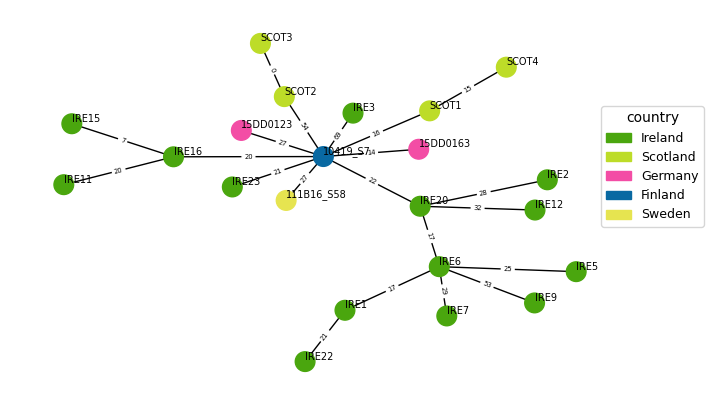

In [81]:
reload(tools)
fig,ax=plt.subplots(1,1,figsize=(8,5))
x=gdm.loc[clade1,clade1]
T,pos = tools.dist_matrix_to_mst(x,gmeta,colorcol='country',colormap=mycolors,edge_labels=True,font_size=7,
                                 labelcol='strain',node_size=200,ax=ax)
fig.savefig('figure2a.png',dpi=200)

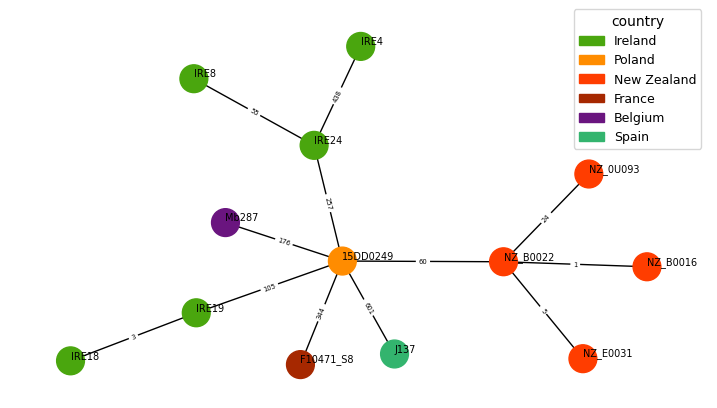

In [80]:
reload(tools)
fig,ax=plt.subplots(1,1,figsize=(9,5))
x=gdm.loc[clade2,clade2]
T,pos = tools.dist_matrix_to_mst(x,gmeta,colorcol='country',colormap=mycolors,edge_labels=True,font_size=7,
                                 labelcol='strain',node_size=400,legend_loc=(.9,.9),ax=ax)
fig.savefig('figure2b.png',dpi=300)

In [ ]:
sub = gmeta.loc[clade1]
rcolors = list(sub.country.map(mycolors))
lower_matrix_clustermap(x, rcolors)

In [ ]:
nzdm = pd.read_csv('panaroo_NZ/snpdist.tsv',sep='\t',index_col=0)
nzmeta = pd.read_csv('PRJNA664415_runTable.csv').set_index('Run')
fig,ax=plt.subplots(1,1,figsize=(12,6))
idx=list(nzdm.sample(90).index)
idx.extend(['245','243-B21'])
x=nzdm.loc[idx,idx]
T,pos = tools.dist_matrix_to_mst(x,gmeta,colorcol='country',colormap=mycolors,edge_labels=True,font_size=9,#labelcol='strain'
                                 node_size=20,ax=ax)

In [ ]:
tools.get_closest_samples(nzdm,'245',n=12)
#sns.clustermap(x,annot=True, annot_kws={'size':6},fmt='.0f')

In [350]:
def draw_circle(G, pos, nodes, ax):
    """circle node group"""
    
    #print (nodes)
    cluster_center = [pos[node] for node in nodes]
    x, y = zip(*cluster_center)
    circle = plt.Circle((sum(x) / len(nodes), sum(y) / len(nodes)), radius=100, edgecolor='blue', facecolor='none')
    ax.add_patch(circle)
    

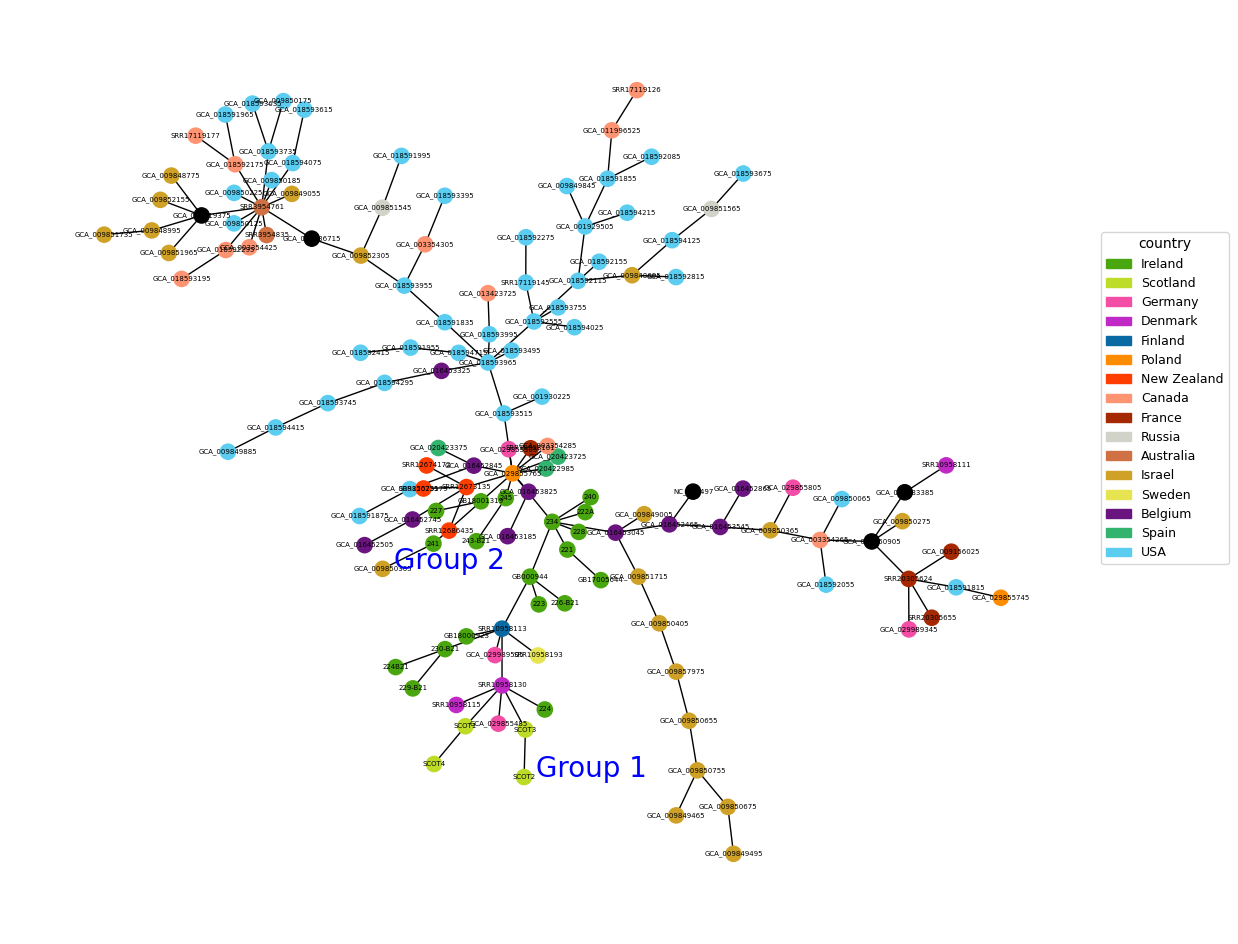

In [76]:
reload(tools)
fig,ax=plt.subplots(1,1,figsize=(14,12))
#T,pos = tools.dist_matrix_to_mst(gdm, gmeta, colorcol='country', colormap=mycolors, 
#                           node_size=120, font_size=5, ax=ax, labelcol='strain', edge_labels=True)
T,pos = tools.dist_matrix_to_mst(gdm, gmeta, colorcol='country', colormap=mycolors, 
                           node_size=120, font_size=5, ax=ax, with_labels=True)
#draw_circle(T, pos, clade1, ax)
ax.text(pos['SCOT2'][0]+20, pos['SCOT2'][1], 'Group 1', fontsize=20, color='blue')
ax.text(pos['GCA_009850305'][0]+20, pos['GCA_009850305'][1], 'Group 2', fontsize=20, color='blue')

fig.savefig('MST.png',dpi=300)

## coverage

In [ ]:
reload(tools)
n=8
fig,ax=plt.subplots(n-1,1,figsize=(25,12))
axs=ax.flat
i=0
for idx,r in df.sample(n).iterrows(): 
    #print (r.bam_file)
    if pd.isnull(r.bam_file): continue   
    d=tools.samtools_depth(r.bam_file, start=180000,end=300000)
    x=groupby_interval(d,500,1000)
    ax=axs[i]
    x.plot(kind='area',ax=ax)
    label = r['sample']
    ax.text(.05,.8,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([])
    i+=1
sns.despine()
plt.tight_layout()

In [5]:
def groupby_interval(df, clip=2, interval=100):
    """Group over an interval - used for samtools depth data"""
    
    min = df.pos.min()
    max=df.pos.max()
    b = np.arange(min, max, interval)
    #rint (b)
    x=df.groupby(pd.cut(df.pos, bins=b, labels=b[:-1], right=False)).mean(numeric_only=True)['depth']
    x = x.clip(0,clip)
    x = x.replace(0,np.nan)
    return x.dropna()

In [ ]:
d=tools.samtools_depth('results/mapped/222A.bam')
data=groupby_interval(d,500,1000).dropna()
data

In [ ]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch

# Load Genbank file
gbk_file = 'NC_014760.gb'
gbk = Genbank(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size}, start=0, end=320)
sector = circos.get_sector(gbk.name)
major_ticks_interval = 200000
minor_ticks_interval = 50000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="red")
r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="blue")

n=8
i=70
h=6
text_common_kws = dict(ha="right", va="center", size=8)
for idx,r in df.sample(n).iterrows(): 
    name = r['sample']
    if pd.isnull(r.bam_file): continue   
    d = tools.samtools_depth(r.bam_file)#, start=200000,end=350000)
    data = groupby_interval(d,500,2000)
    x=data.index
    y=data.values
    track = sector.add_track((i, i+h), r_pad_ratio=0.1)
    track.axis()
    #track.line(x, y)
    track.fill_between(x, y, ec="black", lw=.2)
    i-=h
    circos.text(name, r=i+h+2, color="black", **text_common_kws)

fig = circos.plotfig(160)

In [ ]:
from pycirclize import Circos
from io import StringIO
from Bio import Phylo
import numpy as np

np.random.seed(0)

tree = Phylo.read('results/tree.newick', "newick")
leaf_num = tree.count_terminals()

# Initialize circos sector with tree size
circos = Circos(sectors={"Tree": leaf_num}, start=-350, end=0)
sector = circos.sectors[0]

# Plot tree
tree_track = sector.add_track((30, 80))
tree_track.tree(
    tree,
    use_branch_length=True, 
    leaf_label_size=10,
    leaf_label_margin=2, # Set large margin for heatmap plot
    
)

# Plot heatmap
heatmap_track = sector.add_track((100, 120))
matrix_data = np.random.randint(0, 100, (5, leaf_num))
heatmap_track.heatmap(matrix_data, cmap="viridis")
heatmap_track.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmax=5, tick_length=0)

fig = circos.plotfig()


## kraken

In [ ]:
reload(tools)
f1 = '/storage/catherine/data/222A_S3_L001-4_R1_001.fastq.gz'
f2 = '/storage/catherine/data/222A_S3_L001-4_R2_001.fastq.gz'
rep=tools.kraken(f1, f2, threads=8)

In [ ]:
res=[]
found = pd.read_csv('/storage/catherine/contam_kraken.csv')
samples = pd.read_csv('/storage/catherine/results/samples.csv')

for i,r in samples.iterrows():
    name = r['sample']
    print (name)
    if name in list(found['sample']):
        continue
    rep = tools.kraken(r.filename1,r.filename2, threads=8)    
    rep=rep[rep.perc_frag>0.1]    
    rep['sample'] = name
    res.append(rep)
if len(res)>0:
    df=pd.concat(res)
    found = pd.concat([found,df])
    #found = df
    found.to_csv('/other/catherine/contam_kraken.csv',index=False)

In [ ]:
found = pd.read_csv('/other/catherine/contam_kraken.csv')
x=found[found.rank_code=='S']
contam = x.pivot_table(index='sample',columns='name',values='perc_frag').fillna(0)
ax=plt.subplots(1,1,figsize=(12,6))
sns.heatmap(contam,lw=1,cmap='Blues',annot=True,yticklabels=True)

## kSNP commands

```
/local/kSNP4.1/MakeKSNP4infile -indir entrez_assemblies/ -outfile entrez_genomes.txt
/local/kSNP4.1/kSNP4 -core -k 31 -outdir ksnp_assembled -in assembled_genomes.txt
```

In [ ]:
def get_assembly_summary(id):
    """Get esummary for an entrez id"""
    
    from Bio import Entrez
    esummary_handle = Entrez.esummary(db="assembly", id=id, report="full")
    esummary_record = Entrez.read(esummary_handle)
    return esummary_record

def get_assemblies(term):
    """Download genbank assembly meta data for a given search term.
    Args:
        term: search term, usually organism name        
    """

    from Bio import Entrez
    from tqdm import tqdm
    #provide your own mail here
    Entrez.email = "A.N.Other@example.com"
    handle = Entrez.esearch(db="assembly", term=term, retmax='5000')
    record = Entrez.read(handle)
    ids = record['IdList']
    print (f'found {len(ids)} ids')
    links = []
    result = []
    for id in tqdm(ids):
        row = {'id':id}
        #get summary
        rec = get_assembly_summary(id)
        #print (id)        
        asm_summ = rec['DocumentSummarySet']['DocumentSummary'][0]       
        fields = ['AssemblyAccession','BioSampleAccn','BioSampleId','SubmitterOrganization']
        for key in fields:
            row[key] = asm_summ[key]
        row['GenbankAccession'] = asm_summ['Synonym']['Genbank']
        
        #biosample info is a separate request using the BioSampleId
        handle = Entrez.esummary(db="biosample", id=asm_summ['BioSampleId'], report="full")        
        rec2 = Entrez.read(handle)
        sampledata = rec2['DocumentSummarySet']['DocumentSummary'][0]['SampleData']
        #parse xml in sampledata
        from bs4 import BeautifulSoup
        soup = BeautifulSoup(sampledata)
        all_attr = soup.findAll('attribute')        
        for attr in all_attr:
            #print (attr,attr['attribute_name'],attr.text)
            row[attr['attribute_name']] = attr.text
        #get url
        #url = asm_summ['FtpPath_RefSeq']
        url = asm_summ['FtpPath_GenBank']
        #print (url)
        if url != '':           
            label = os.path.basename(url)
            #get the fasta link - change this to get other formats
            link = os.path.join(url,label+'.fna.gz')        
            row['link'] = link
        result.append(row)
    result = pd.DataFrame(result)
    return result

def download_links(df, path):
    for i,r in df.iterrows():
        label = r.AssemblyAccession
        urllib.request.urlretrieve(link, os.path.join(path, f'{label}.fna.gz'))
        
res = get_assemblies('Mycoplasmopsis bovis')

## reduced kSNP files

In [ ]:
njdm = pd.read_csv('ksnp_entrez/NJ.dist.matrix', sep='\s+').reset_index().set_index('level_0')
njdm.columns = list(njdm.index)
#njdm.to_csv('ksnp_entez/njdm.csv',index=True)

In [65]:
cl,memb=clustering.get_cluster_levels(njdm, levels=[3,7,12,20,40])

In [839]:
#final = final.merge(cl, left_index=True, right_index=True)
#final.to_csv('global_meta.csv')

In [ ]:
reduced = clustering.nonredundant_samples(cl, col='snp3')
keep = samples[:29]['sample']
reduced = pd.concat([reduced,cl.loc[keep]])
reduced = reduced[~reduced.index.duplicated(keep='last')]
#reduced.to_csv('assembly_reduced.csv')
len(reduced)

In [ ]:
final.year.value_counts()

In [687]:
#make reduced ksnp file
lines=''
for i,r in reduced.iterrows():    
    s= '/other/catherine/entrez_assemblies/{i}.fna\t{i}\n'.format(i=i)
    lines+=s
#with open('reduced_genomes.txt', 'w') as f:
#    f.write(lines)

## get kSNP snp dists

In [679]:
aln = AlignIO.read('ksnp_reduced/SNPs_all_matrix.fasta', 'fasta')
ls = len(aln[0])
trees.convert_branch_lengths('ksnp_reduced/tree.core_SNPs.parsimony.tre','ksnp_reduced/tree.newick', ls)

In [ ]:
kdm = pd.read_csv('ksnp_reduced/snpdist.tsv',sep='\t',index_col=0)
kdm_core = pd.read_csv('ksnp_reduced/snpdist_core.tsv',sep='\t',index_col=0)
x=kdm.loc[clade2,clade2]
#lower_matrix_clustermap(x)
lower_matrix_clustermap(kdm)

## vsp genes

In [9]:
def find_genes(target, query, ident=90, coverage=75, duplicates=False, threads=2, **kwds):
    """Find ref genes by blasting the target sequences"""

    from Bio.SeqRecord import SeqRecord
    from Bio.Seq import Seq
    from Bio import SeqIO

    queryseqs = list(SeqIO.parse(query,'fasta'))
    print ('blasting %s sequences' %len(queryseqs))
    bl = tools.blast_sequences(target, queryseqs, maxseqs=1, evalue=1e-4,
                               cmd='blastn', show_cmd=True, threads=int(threads))

    #print (bl.iloc[0])
    bl['qlength'] = bl.qseq.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)
    #bl['contig'] = bl.sseqid.apply(lambda x: x.split('_')[1],1)
    try:
        bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    except:
        bl['gene'] = bl.qseqid

    #remove exact and close duplicates
    print (len(bl))
    bl = bl.sort_values(['bitscore'], ascending=False).drop_duplicates(['sstart','send'])
    print (len(bl))
    if duplicates == False:
        dist = 20
        x=bl.sort_values(by=["sstart"],ascending=False)
        #print (x[:15][x.columns[:5]])
        unique = x.sstart.diff().abs().fillna(dist)
        bl = bl[unique>=dist]
    cols = ['gene','id','qseqid','pident','coverage','sstart','send','filename','bitscore']
    #print (bl)
    bl = bl[cols]
    return bl

In [ ]:
#blast to vsp genes directly
blastres=[]
for name,r in reduced.iterrows():
    print (name)
    target = 'entrez_assemblies/%s.fna' %name
    if not os.path.exists(target):
        target = 'assembled/%s.fa' %name
        if not os.path.exists(target): continue            
    print (target)
    tools.make_blast_database(target,dbtype='nucl')
    bl = find_genes(target,'vsp.fa',ident=95,coverage=95,threads=16)
    bl['sample'] = name    
    blastres.append(bl)
blastres = pd.concat(blastres)

In [ ]:
#x = bl.drop_duplicates(['sstart'])
m = pd.pivot_table(blastres, index='sample', columns='gene', values='pident').fillna(0)
m[m>0] = 1
sns.clustermap(m, yticklabels=True,figsize=(10,9), cmap='Reds')

In [847]:
xx=final.merge(m,left_index=True,right_index=True,how='left')
xx.to_csv('global_meta.csv')

## get NZ samples

In [ ]:
nz = pd.read_csv('PRJNA664415_runTable.csv')
for i,r in nz.sample(30).iterrows():
    print (r.Run)
    file = 'NZ/'+r.Run+'*.*'
    e = glob.glob(file)
    if len(e)>0: continue
    cmd = 'fastq-dump --split-files %s' %r.Run
    print (cmd)
    subprocess.check_output(cmd, shell=True)

## MLST

get genes from prokka annotation and check against profiles from pubmlst

* loci: 'dnaA','gltX','gpsA','gyrB','tdk','tkt', 'pta2'
* retrieve gene equences for each locus at: https://rest.pubmlst.org/db/pubmlst_mbovis_seqdef/loci/{locus}/alleles_fasta
* retrieve profiles: https://rest.pubmlst.org/db/pubmlst_mbovis_seqdef/schemes/2/profiles_csv


In [297]:
# blast each allele for query assembly

for gene in loci:   
    db = f'MLST/{gene}.fa'
    tools.make_blast_database(db)

def get_pubmlst_profile(fasta_file, cutoff=100):
    loci = ['dnaA','gltX','gpsA','gyrB','pta2','tdk','tkt']    
    profile=[]
    for gene in loci:
        #print (gene)
        db = f'MLST/{gene}.fa'    
        bl = tools.blast_fasta(db, fasta_file)
        bl = bl[(bl.pident>=cutoff)]
        #print (bl)
        if len(bl)>0:
            res = bl.iloc[0]             
            #print (res)
            hit = res.stitle        
        else:
            hit = None
            #print ('no hit')
        profile.append(hit)
    #extract ST numbers
    profile = [i[-1:] if i!=None else None for i in profile]
    return profile

p=get_pubmlst_profile('assembled/PURE.fa')


In [285]:
def get_st(profile):
    
    df = pd.read_csv('MLST/profiles.csv',sep='\t').astype(str)
    #print (df)
    # Iterate over each row
    if None in profile:
        return
    s = ''.join(profile)
    for index, row in df.iterrows():
        row_str = ''.join(list(row[1:8]))
        #print (row.ST)
        #print (s,row_str)
        if s == row_str:
            return row.ST
    return

print (p)
get_st(p)

['1', '2', '4', '2', '1', '3', '2']


'12'

In [301]:
res=[]
#paths = glob.glob('assembled/*.fa')
genomes=pd.read_csv('reduced_genomes.txt',sep='\t',names=['file','name'])
paths=list(genomes.file)

for file in paths[-20:-10]:
    name = os.path.splitext(os.path.basename(file))[0]
    p = get_pubmlst_profile(file, 99)
    st = get_st(p)
    print(file,p,st)
    res.append([name,p,st])
res=pd.DataFrame(res,columns=['name','profile','ST'])
#res.to_csv('st_types.csv',index=False)

/other/catherine/assembled/227.fa ['1', '3', '3', '3', '5', '3', '6'] 122
/other/catherine/assembled/240.fa ['1', '7', '3', '5', '2', '2', '3'] None
/other/catherine/assembled/241.fa ['1', '3', '3', '3', '2', '3', '6'] 21
/other/catherine/assembled/SRR20305655.fa ['1', '2', '1', '4', '5', '1', '3'] 8
/other/catherine/assembled/GB18001319.fa ['1', '3', '3', '3', '2', '3', '6'] 21
/other/catherine/assembled/GB17005644.fa ['1', '3', '3', '5', '2', '2', '3'] 29
/other/catherine/assembled/234.fa ['1', '3', '3', '5', '2', '2', '3'] 29
/other/catherine/assembled/230-B21.fa ['1', '3', '3', '5', '2', '2', '3'] 29
/other/catherine/assembled/SRR17119126.fa ['5', '3', '0', '3', '5', '2', '4'] None
/other/catherine/assembled/SRR17119177.fa ['4', '3', '2', '3', '2', '3', '6'] None


In [ ]:
/other/catherine/assembled/227.fa ['1', '3', None, '3', '5', '3', '6'] None
/other/catherine/assembled/240.fa ['1', '7', '3', '5', '2', '2', '3'] None
/other/catherine/assembled/241.fa ['1', '3', '3', '3', '2', '3', '6'] 21
/other/catherine/assembled/SRR20305655.fa ['1', '2', '1', '4', '5', '1', '3'] 8
/other/catherine/assembled/GB18001319.fa ['1', '3', '3', '3', '2', '3', '6'] 21
/other/catherine/assembled/GB17005644.fa ['1', '3', '3', '5', '2', '2', '3'] 29
/other/catherine/assembled/234.fa ['1', '3', '3', '5', '2', '2', '3'] 29
/other/catherine/assembled/230-B21.fa ['1', '3', None, '5', '2', '2', '3'] None
/other/catherine/assembled/SRR17119126.fa ['5', '3', '0', '3', '5', '2', '4'] None
/other/catherine/assembled/SRR17119177.fa ['4', '3', '2', None, '2', '3', '6'] None